In [150]:
import glob
import json
import os
import shutil
import operator
import sys
import argparse
import math

import numpy as np

MINOVERLAP = 0.5 # default value (defined in the PASCAL VOC2012 challenge)

In [151]:
cd /home/purva/Desktop/purva/ssd/

/home/purva/Desktop/purva/ssd


In [152]:
ignore = []

specific_iou_flagged = False
set_class_iou= None
no_animation = True
show_animation=False
import matplotlib.pyplot as plt
draw_plot = True
no_plot = False


In [153]:
os.getcwd()

'/home/purva/Desktop/purva/ssd'

In [154]:
GT_PATH = os.path.join(os.getcwd(), 'input', 'ground_truth')
DR_PATH = os.path.join(os.getcwd(), 'input', 'detection_results')
IMG_PATH = '/home/purva/Desktop/purva/Single_shot_detector/VOC2007_Test/JPEGImages/'

In [155]:
print(DR_PATH)
print(GT_PATH)

/home/purva/Desktop/purva/ssd/input/detection_results
/home/purva/Desktop/purva/ssd/input/ground_truth


In [156]:
path="/home/purva/Desktop/purva/ssd/input/detection_results/"
list_=[]
import os
for file in os.listdir(path):
    if file.endswith(".txt"):
        list_.append(os.path.join(path, file))
len(list_)

4636

In [157]:
a=0

In [158]:
for file in list_:
    fh = open(file, "r")
    lines = fh.readlines()
    fh.close()
    if lines==[]:
        a=a+1
        os.remove(file)

In [159]:
GT_PATH

'/home/purva/Desktop/purva/ssd/input/ground_truth'

In [160]:
os.chdir(GT_PATH)
gt_files = glob.glob('*.txt')
if len(gt_files) == 0:
    print("Error: no .txt files found in", GT_PATH)
    
os.chdir(DR_PATH)
dr_files = glob.glob('*.txt')
if len(dr_files) == 0:
    print("Error: no .txt files found in", DR_PATH)
    
gt_files = set(gt_files)
dr_files = set(dr_files)
print('total ground-truth files:', len(gt_files))
print('total detection-results files:', len(dr_files))
print()
backup_folder = 'backup_no_matches_found'

total ground-truth files: 4636
total detection-results files: 4636



In [161]:
gt_backup = gt_files - dr_files
dr_backup = dr_files - gt_files

def backup(src_folder, backup_files, backup_folder):
    # non-intersection files (txt format) will be moved to a backup folder
    if not backup_files:
        print('No backup required for', src_folder)
        return
    os.chdir(src_folder)
    ## create the backup dir if it doesn't exist already
    if not os.path.exists(backup_folder):
        os.makedirs(backup_folder)
    for file in backup_files:
        os.rename(file, backup_folder + '/' + file)
    
backup(GT_PATH, gt_backup, backup_folder)
backup(DR_PATH, dr_backup, backup_folder)
if gt_backup:
    print('total ground-truth backup files:', len(gt_backup))
if dr_backup:
    print('total detection-results backup files:', len(dr_backup))

intersection = gt_files & dr_files
print('total intersected files:', len(intersection))
print("Intersection completed!")

No backup required for /home/purva/Desktop/purva/ssd/input/ground_truth
No backup required for /home/purva/Desktop/purva/ssd/input/detection_results
total intersected files: 4636
Intersection completed!


In [162]:
GT_PATH 

'/home/purva/Desktop/purva/ssd/input/ground_truth'

In [163]:
IMG_PATH = '/home/purva/Desktop/purva/Single_shot_detector/VOC2007_Test/JPEGImages/'

In [164]:
import sys
import os
import glob
import glob
import json
import os
import shutil
import operator
import sys
import argparse
import math

import numpy as np

MINOVERLAP = 0.5 # default value (defined in the PASCAL VOC2012 challenge)

In [165]:
no_animation = True
show_animation= False
import matplotlib.pyplot as plt
draw_plot = True
no_plot = False

In [166]:
def log_average_miss_rate(precision, fp_cumsum, num_images):
    
    if precision.size == 0:
        lamr = 0
        mr = 1
        fppi = 0
        return lamr, mr, fppi

    fppi = fp_cumsum / float(num_images)
    mr = (1 - precision)

    fppi_tmp = np.insert(fppi, 0, -1.0)
    mr_tmp = np.insert(mr, 0, 1.0)

    # Use 9 evenly spaced reference points in log-space
    ref = np.logspace(-2.0, 0.0, num = 9)
    for i, ref_i in enumerate(ref):
        # np.where() will always find at least 1 index, since min(ref) = 0.01 and min(fppi_tmp) = -1.0
        j = np.where(fppi_tmp <= ref_i)[-1][-1]
        ref[i] = mr_tmp[j]

    # log(0) is undefined, so we use the np.maximum(1e-10, ref)
    lamr = math.exp(np.mean(np.log(np.maximum(1e-10, ref))))

    return lamr, mr, fppi

In [167]:
def error(msg):
    print(msg)
    


In [168]:
def is_float_between_0_and_1(value):
    try:
        val = float(value)
        if val > 0.0 and val < 1.0:
            return True
        else:
            return False
    except ValueError:
        return False

In [169]:
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre

In [170]:
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    return content

In [171]:
def adjust_axes(r, t, fig, axes):
    # get text width for re-scaling
    bb = t.get_window_extent(renderer=r)
    text_width_inches = bb.width / fig.dpi
    # get axis width in inches
    current_fig_width = fig.get_figwidth()
    new_fig_width = current_fig_width + text_width_inches
    propotion = new_fig_width / current_fig_width
    # get axis limit
    x_lim = axes.get_xlim()
    axes.set_xlim([x_lim[0], x_lim[1]*propotion])

In [172]:
def draw_text_in_image(img, text, pos, color, line_width):
    font = cv2.FONT_HERSHEY_PLAIN
    fontScale = 1
    lineType = 1
    bottomLeftCornerOfText = pos
    cv2.putText(img, text,
            bottomLeftCornerOfText,
            font,
            fontScale,
            color,
            lineType)
    text_width, _ = cv2.getTextSize(text, font, fontScale, lineType)[0]
    return img, (line_width + text_width)

In [173]:
def adjust_axes(r, t, fig, axes):
    # get text width for re-scaling
    bb = t.get_window_extent(renderer=r)
    text_width_inches = bb.width / fig.dpi
    # get axis width in inches
    current_fig_width = fig.get_figwidth()
    new_fig_width = current_fig_width + text_width_inches
    propotion = new_fig_width / current_fig_width
    # get axis limit
    x_lim = axes.get_xlim()
    axes.set_xlim([x_lim[0], x_lim[1]*propotion])


In [174]:
def draw_text_in_image(img, text, pos, color, line_width):
    font = cv2.FONT_HERSHEY_PLAIN
    fontScale = 1
    lineType = 1
    bottomLeftCornerOfText = pos
    cv2.putText(img, text,
            bottomLeftCornerOfText,
            font,
            fontScale,
            color,
            lineType)
    text_width, _ = cv2.getTextSize(text, font, fontScale, lineType)[0]
    return img, (line_width + text_width)

In [175]:
def draw_plot_func(dictionary, n_classes, window_title, plot_title, x_label, output_path, to_show, plot_color, true_p_bar):
    # sort the dictionary by decreasing value, into a list of tuples
    sorted_dic_by_value = sorted(dictionary.items(), key=operator.itemgetter(1))
    # unpacking the list of tuples into two lists
    sorted_keys, sorted_values = zip(*sorted_dic_by_value)
    # 
    if true_p_bar != "":
        """
         Special case to draw in:
            - green -> TP: True Positives (object detected and matches ground-truth)
            - red -> FP: False Positives (object detected but does not match ground-truth)
            - orange -> FN: False Negatives (object not detected but present in the ground-truth)
        """
        fp_sorted = []
        tp_sorted = []
        for key in sorted_keys:
            fp_sorted.append(dictionary[key] - true_p_bar[key])
            tp_sorted.append(true_p_bar[key])
        plt.barh(range(n_classes), fp_sorted, align='center', color='crimson', label='False Positive')
        plt.barh(range(n_classes), tp_sorted, align='center', color='forestgreen', label='True Positive', left=fp_sorted)
        # add legend
        plt.legend(loc='lower right')
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            fp_val = fp_sorted[i]
            tp_val = tp_sorted[i]
            fp_str_val = " " + str(fp_val)
            tp_str_val = fp_str_val + " " + str(tp_val)
            # trick to paint multicolor with offset:
            # first paint everything and then repaint the first number
            t = plt.text(val, i, tp_str_val, color='forestgreen', va='center', fontweight='bold')
            plt.text(val, i, fp_str_val, color='crimson', va='center', fontweight='bold')
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    else:
        plt.barh(range(n_classes), sorted_values, color=plot_color)
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            str_val = " " + str(val) # add a space before
            if val < 1.0:
                str_val = " {0:.2f}".format(val)
            t = plt.text(val, i, str_val, color=plot_color, va='center', fontweight='bold')
            # re-set axes to show number inside the figure
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    # set window title
    fig.canvas.set_window_title(window_title)
    # write classes in y axis
    tick_font_size = 12
    plt.yticks(range(n_classes), sorted_keys, fontsize=tick_font_size)
    """
     Re-scale height accordingly
    """
    init_height = fig.get_figheight()
    # comput the matrix height in points and inches
    dpi = fig.dpi
    height_pt = n_classes * (tick_font_size * 1.4) # 1.4 (some spacing)
    height_in = height_pt / dpi
    # compute the required figure height 
    top_margin = 0.15 # in percentage of the figure height
    bottom_margin = 0.05 # in percentage of the figure height
    figure_height = height_in / (1 - top_margin - bottom_margin)
    # set new height
    if figure_height > init_height:
        fig.set_figheight(figure_height)

    # set plot title
    plt.title(plot_title, fontsize=14)
    # set axis titles
    # plt.xlabel('classes')
    plt.xlabel(x_label, fontsize='large')
    # adjust size of window
    fig.tight_layout()
    # save the plot
    fig.savefig(output_path)
    # show image
    if to_show:
        plt.show()
    # close the plot
    plt.close()

In [176]:
pwd

'/home/purva/Desktop/purva/ssd/input/detection_results'

In [178]:
TEMP_FILES_PATH = ".temp_files"
if not os.path.exists(TEMP_FILES_PATH): # if it doesn't exist already
    os.makedirs(TEMP_FILES_PATH)
results_files_path ="/home/purva/Desktop/purva/ssd/input/detection_results/results"
if not os.path.exists(results_files_path): # if it doesn't exist already
    os.makedirs(results_files_path)
if os.path.exists(results_files_path): # if it exist already
    # reset the results directory
    shutil.rmtree(results_files_path)

In [179]:
os.path.abspath(TEMP_FILES_PATH)

'/home/purva/Desktop/purva/ssd/input/detection_results/.temp_files'

In [180]:
os.makedirs(results_files_path)
if draw_plot:
    os.makedirs(os.path.join(results_files_path, "classes"))
if show_animation:
    os.makedirs(os.path.join(results_files_path, "images", "detections_one_by_one"))

In [181]:
os.path.abspath(TEMP_FILES_PATH)

'/home/purva/Desktop/purva/ssd/input/detection_results/.temp_files'

In [185]:
class_path = os.path.join(results_files_path, "classes")
if draw_plot:
    if not os.path.exists(class_path):
        os.makedirs(class_path)
        
        
animation_path = os.path.join(results_files_path, "images", "detections_one_by_one")

if show_animation:
    if not os.path.exists(class_path):
        os.makedirs(animation_path)

In [186]:
ground_truth_files_list = glob.glob(GT_PATH + '/*.txt')
if len(ground_truth_files_list) == 0:
    error("Error: No ground-truth files found!")
ground_truth_files_list.sort()
# dictionary with counter per class
gt_counter_per_class = {}
counter_images_per_class = {}

In [187]:
txt_file=ground_truth_files_list[0]
file_id = txt_file.split(".txt", 1)[0]
file_id = os.path.basename(os.path.normpath(file_id))
temp_path = os.path.join(DR_PATH, (file_id + ".txt"))

lines_list = file_lines_to_list(txt_file)
lines_list

['dog 48 240 195 371', 'person 8 12 352 498']

In [188]:
for txt_file in ground_truth_files_list:
    #print(txt_file)
    file_id = txt_file.split(".txt", 1)[0]
    file_id = os.path.basename(os.path.normpath(file_id))
    # check if there is a correspondent detection-results file
    temp_path = os.path.join(DR_PATH, (file_id + ".txt"))
    if not os.path.exists(temp_path):
        error_msg = "Error. File not found: {}\n".format(temp_path)
        error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
        error(error_msg)
    lines_list = file_lines_to_list(txt_file)
    # create ground-truth dictionary
    bounding_boxes = []
    is_difficult = False
    already_seen_classes = []
    for line in lines_list:
        try:
            if "difficult" in line:
                    class_name, left, top, right, bottom, _difficult = line.split()
                    is_difficult = True
            else:
                    class_name, left, top, right, bottom = line.split()
        except ValueError:
            error_msg = "Error: File " + txt_file + " in the wrong format.\n"
            error_msg += " Expected: <class_name> <left> <top> <right> <bottom> ['difficult']\n"
            error_msg += " Received: " + line
            error_msg += "\n\nIf you have a <class_name> with spaces between words you should remove them\n"
            error_msg += "by running the script \"remove_space.py\" or \"rename_class.py\" in the \"extra/\" folder."
            error(error_msg)
        # check if class is in the ignore list, if yes skip
        if class_name in ignore:
            continue
        bbox = left + " " + top + " " + right + " " +bottom
        if is_difficult:
                bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False, "difficult":True})
                is_difficult = False
        else:
                bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False})
                # count that object
                if class_name in gt_counter_per_class:
                    gt_counter_per_class[class_name] += 1
                else:
                    # if class didn't exist yet
                    gt_counter_per_class[class_name] = 1

                if class_name not in already_seen_classes:
                    if class_name in counter_images_per_class:
                        counter_images_per_class[class_name] += 1
                    else:
                        # if class didn't exist yet
                        counter_images_per_class[class_name] = 1
                    already_seen_classes.append(class_name)


    # dump bounding_boxes into a ".json" file
    with open(TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json", 'w') as outfile:
        json.dump(bounding_boxes, outfile)
gt_classes = list(gt_counter_per_class.keys())
gt_classes = sorted(gt_classes)
n_classes = len(gt_classes)

In [54]:
dr_files_list = glob.glob(DR_PATH + '/*.txt')
dr_files_list.sort()
for class_index, class_name in enumerate(gt_classes):
    bounding_boxes = []
    for txt_file in dr_files_list:
        #print(txt_file)
        # the first time it checks if all the corresponding ground-truth files exist
        file_id = txt_file.split(".txt",1)[0]
        file_id = os.path.basename(os.path.normpath(file_id))
        temp_path = os.path.join(GT_PATH, (file_id + ".txt"))
        if class_index == 0:
            if not os.path.exists(temp_path):
                error_msg = "Error. File not found: {}\n".format(temp_path)
                error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
                error(error_msg)
        lines = file_lines_to_list(txt_file)
        for line in lines:
            try:
                tmp_class_name, confidence, left, top, right, bottom = line.split()
            except ValueError:
                error_msg = "Error: File " + txt_file + " in the wrong format.\n"
                error_msg += " Expected: <class_name> <confidence> <left> <top> <right> <bottom>\n"
                error_msg += " Received: " + line
                error(error_msg)
            if tmp_class_name == class_name:
                #print("match")
                bbox = left + " " + top + " " + right + " " +bottom
                bounding_boxes.append({"confidence":confidence, "file_id":file_id, "bbox":bbox})
                #print(bounding_boxes)
    # sort detection-results by decreasing confidence
    bounding_boxes.sort(key=lambda x:float(x['confidence']), reverse=True)
    with open(TEMP_FILES_PATH + "/" + class_name + "_dr.json", 'w') as outfile:
        json.dump(bounding_boxes, outfile)

In [189]:
txt_file=dr_files_list[1]
file_id = txt_file.split(".txt",1)[0]
file_id = os.path.basename(os.path.normpath(file_id))
temp_path = os.path.join(GT_PATH, (file_id + ".txt"))
lines = file_lines_to_list(txt_file)
for line in lines:
    tmp_class_name, confidence, left, top, right, bottom = line.split()
tmp_class_name

'train'

68.81% = aeroplane AP 
56.67% = bicycle AP 
51.05% = bird AP 
36.47% = boat AP 
12.36% = bottle AP 
64.19% = bus AP 
60.80% = car AP 
79.03% = cat AP 
22.55% = chair AP 
45.12% = cow AP 
49.76% = diningtable AP 
64.91% = dog AP 
69.61% = horse AP 
52.20% = motorbike AP 
45.60% = person AP 
30.36% = pottedplant AP 
44.17% = sheep AP 
52.13% = sofa AP 
78.92% = train AP 
58.15% = tvmonitor AP 
mAP = 52.14%


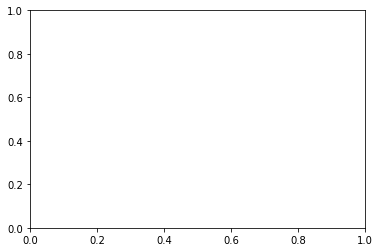

In [190]:
import cv2
sum_AP = 0.0
ap_dictionary = {}
lamr_dictionary = {}
# open file to store the results
with open(results_files_path + "/results.txt", 'w') as results_file:
    results_file.write("# AP and precision/recall per class\n")
    count_true_positives = {}
    for class_index, class_name in enumerate(gt_classes):
        count_true_positives[class_name] = 0
        """
         Load detection-results of that class
        """
        dr_file = TEMP_FILES_PATH + "/" + class_name + "_dr.json"
        dr_data = json.load(open(dr_file))

        """
         Assign detection-results to ground-truth objects
        """
        nd = len(dr_data)
        tp = [0] * nd # creates an array of zeros of size nd
        fp = [0] * nd
        for idx, detection in enumerate(dr_data):
            file_id = detection["file_id"]
            if show_animation:
                # find ground truth image
                ground_truth_img = glob.glob1(IMG_PATH, file_id + ".*")
                #tifCounter = len(glob.glob1(myPath,"*.tif"))
                if len(ground_truth_img) == 0:
                    error("Error. Image not found with id: " + file_id)
                elif len(ground_truth_img) > 1:
                    error("Error. Multiple image with id: " + file_id)
                else: # found image
                    #print(IMG_PATH + "/" + ground_truth_img[0])
                    # Load image
                    img = cv2.imread(IMG_PATH + "/" + ground_truth_img[0])
                    # load image with draws of multiple detections
                    img_cumulative_path = results_files_path + "/images/" + ground_truth_img[0]
                    if os.path.isfile(img_cumulative_path):
                        img_cumulative = cv2.imread(img_cumulative_path)
                    else:
                        img_cumulative = img.copy()
                    # Add bottom border to image
                    bottom_border = 60
                    BLACK = [0, 0, 0]
                    img = cv2.copyMakeBorder(img, 0, bottom_border, 0, 0, cv2.BORDER_CONSTANT, value=BLACK)
            # assign detection-results to ground truth object if any
            # open ground-truth with that file_id
            gt_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
            ground_truth_data = json.load(open(gt_file))
            ovmax = -1
            gt_match = -1
            # load detected object bounding-box
            bb = [ float(x) for x in detection["bbox"].split() ]
            for obj in ground_truth_data:
                # look for a class_name match
                if obj["class_name"] == class_name:
                    bbgt = [ float(x) for x in obj["bbox"].split() ]
                    bi = [max(bb[0],bbgt[0]), max(bb[1],bbgt[1]), min(bb[2],bbgt[2]), min(bb[3],bbgt[3])]
                    iw = bi[2] - bi[0] + 1
                    ih = bi[3] - bi[1] + 1
                    if iw > 0 and ih > 0:
                        # compute overlap (IoU) = area of intersection / area of union
                        ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                                        + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                        ov = iw * ih / ua
                        if ov > ovmax:
                            ovmax = ov
                            gt_match = obj

            # assign detection as true positive/don't care/false positive
            if show_animation:
                status = "NO MATCH FOUND!" # status is only used in the animation
            # set minimum overlap
            min_overlap = MINOVERLAP
            if specific_iou_flagged:
                if class_name in specific_iou_classes:
                    index = specific_iou_classes.index(class_name)
                    min_overlap = float(iou_list[index])
            if ovmax >= min_overlap:
                if "difficult" not in gt_match:
                        if not bool(gt_match["used"]):
                            # true positive
                            tp[idx] = 1
                            gt_match["used"] = True
                            count_true_positives[class_name] += 1
                            # update the ".json" file
                            with open(gt_file, 'w') as f:
                                    f.write(json.dumps(ground_truth_data))
                            if show_animation:
                                status = "MATCH!"
                        else:
                            # false positive (multiple detection)
                            fp[idx] = 1
                            if show_animation:
                                status = "REPEATED MATCH!"
            else:
                # false positive
                fp[idx] = 1
                if ovmax > 0:
                    status = "INSUFFICIENT OVERLAP"

            """
             Draw image to show animation
            """
            if show_animation:
                height, widht = img.shape[:2]
                # colors (OpenCV works with BGR)
                white = (255,255,255)
                light_blue = (255,200,100)
                green = (0,255,0)
                light_red = (30,30,255)
                # 1st line
                margin = 10
                v_pos = int(height - margin - (bottom_border / 2.0))
                text = "Image: " + ground_truth_img[0] + " "
                img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                text = "Class [" + str(class_index) + "/" + str(n_classes) + "]: " + class_name + " "
                img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), light_blue, line_width)
                if ovmax != -1:
                    color = light_red
                    if status == "INSUFFICIENT OVERLAP":
                        text = "IoU: {0:.2f}% ".format(ovmax*100) + "< {0:.2f}% ".format(min_overlap*100)
                    else:
                        text = "IoU: {0:.2f}% ".format(ovmax*100) + ">= {0:.2f}% ".format(min_overlap*100)
                        color = green
                    img, _ = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)
                # 2nd line
                v_pos += int(bottom_border / 2.0)
                rank_pos = str(idx+1) # rank position (idx starts at 0)
                text = "Detection #rank: " + rank_pos + " confidence: {0:.2f}% ".format(float(detection["confidence"])*100)
                img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                color = light_red
                if status == "MATCH!":
                    color = green
                text = "Result: " + status + " "
                img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)

                font = cv2.FONT_HERSHEY_SIMPLEX
                if ovmax > 0: # if there is intersections between the bounding-boxes
                    bbgt = [ int(round(float(x))) for x in gt_match["bbox"].split() ]
                    cv2.rectangle(img,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                    cv2.rectangle(img_cumulative,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                    cv2.putText(img_cumulative, class_name, (bbgt[0],bbgt[1] - 5), font, 0.6, light_blue, 1, cv2.LINE_AA)
                bb = [int(i) for i in bb]
                cv2.rectangle(img,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                cv2.rectangle(img_cumulative,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                cv2.putText(img_cumulative, class_name, (bb[0],bb[1] - 5), font, 0.6, color, 1, cv2.LINE_AA)
                # show image
                cv2.imshow("Animation", img)
                cv2.waitKey(20) # show for 20 ms
                # save image to results
                output_img_path = results_files_path + "/images/detections_one_by_one/" + class_name + "_detection" + str(idx) + ".jpg"
                cv2.imwrite(output_img_path, img)
                # save the image with all the objects drawn to it
                cv2.imwrite(img_cumulative_path, img_cumulative)

        #print(tp)
        # compute precision/recall
        cumsum = 0
        for idx, val in enumerate(fp):
            fp[idx] += cumsum
            cumsum += val
        cumsum = 0
        for idx, val in enumerate(tp):
            tp[idx] += cumsum
            cumsum += val
        #print(tp)
        rec = tp[:]
        for idx, val in enumerate(tp):
            rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
        #print(rec)
        prec = tp[:]
        for idx, val in enumerate(tp):
            prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])
        #print(prec)

        ap, mrec, mprec = voc_ap(rec[:], prec[:])
        sum_AP += ap
        text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)
        """
         Write to results.txt
        """
        rounded_prec = [ '%.2f' % elem for elem in prec ]
        rounded_rec = [ '%.2f' % elem for elem in rec ]
        results_file.write(text + "\n Precision: " + str(rounded_prec) + "\n Recall :" + str(rounded_rec) + "\n\n")
        print(text)
        ap_dictionary[class_name] = ap

        n_images = counter_images_per_class[class_name]
        lamr, mr, fppi = log_average_miss_rate(np.array(rec), np.array(fp), n_images)
        lamr_dictionary[class_name] = lamr

        """
         Draw plot
        """
        if draw_plot:
            plt.plot(rec, prec, '-o')
            # add a new penultimate point to the list (mrec[-2], 0.0)
            # since the last line segment (and respective area) do not affect the AP value
            area_under_curve_x = mrec[:-1] + [mrec[-2]] + [mrec[-1]]
            area_under_curve_y = mprec[:-1] + [0.0] + [mprec[-1]]
            plt.fill_between(area_under_curve_x, 0, area_under_curve_y, alpha=0.2, edgecolor='r')
            # set window title
            fig = plt.gcf() # gcf - get current figure
            fig.canvas.set_window_title('AP ' + class_name)
            # set plot title
            plt.title('class: ' + text)
            #plt.suptitle('This is a somewhat long figure title', fontsize=16)
            # set axis titles
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            # optional - set axes
            axes = plt.gca() # gca - get current axes
            axes.set_xlim([0.0,1.0])
            axes.set_ylim([0.0,1.05]) # .05 to give some extra space
            # Alternative option -> wait for button to be pressed
            #while not plt.waitforbuttonpress(): pass # wait for key display
            # Alternative option -> normal display
            #plt.show()
            # save the plot
            fig.savefig(results_files_path + "/classes/" + class_name + ".png")
            plt.cla() # clear axes for next plot

    if show_animation:
        cv2.destroyAllWindows()

    results_file.write("\n# mAP of all classes\n")
    mAP = sum_AP / n_classes
    text = "mAP = {0:.2f}%".format(mAP*100)
    results_file.write(text + "\n")
    print(text)
